**🔹 Import Libraries and Set Hyperparameters**

- Imports the necessary libraries: `pennylane`, `math`, and Pennylane’s version of `numpy`.

- Defines key configuration values:
  - `n_qubits = 4`: Number of qubits used in each quantum circuit.
  - `patch_size = 2`: Each image is divided into 2×2 patches.
  - `layers = 1`: Number of trainable layers in the quantum circuit.
  - `levels = 3`: Number of hierarchical levels (for future multi-layer structure).


In [ ]:
pip install qiskit==1.4.2 tensorflow numpy pandas matplotlib pennylane silence-tensorflow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.7 MB/s eta 0:00:00
  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import warnings
tf.keras.backend.set_floatx('float32')
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

**🔹 Data Loading and Preprocessing**

- Loads the **MNIST** dataset (handwritten digit images).

- **Normalization**: Scales pixel values from **0–255** to **0–1** by dividing by 255.

- Takes one training image (`train_images[0]`) and the first 10 test images (`test_images[0:10]`).

- Converts all image arrays to `float32` type (for compatibility with TensorFlow and PennyLane).

- Displays one training image using **matplotlib** to verify preprocessing.


In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Preprocess training data
img = train_images[0] / 255.0
img = tf.cast(img, tf.float32)
label = train_labels[0]
# Preprocess test data
test_images = test_images[0:10] / 255.0  # Also normalize test images
test_images = tf.cast(test_images, tf.float32)
test_labels = test_labels[0:10]
print("img shape:", img.shape)
print("label:", label)
print("test_images shape:", test_images.shape)
print("test_labels shape:", test_labels.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
img shape: (28, 28)
label: 5
test_images shape: (10, 28, 28)
test_labels shape: (10,)


**🔹 Visualizing the Image**

- Plots the selected training image using `matplotlib`.

- Applies a grayscale colormap (`gray`) for display.

- Displays the digit label as the plot title.


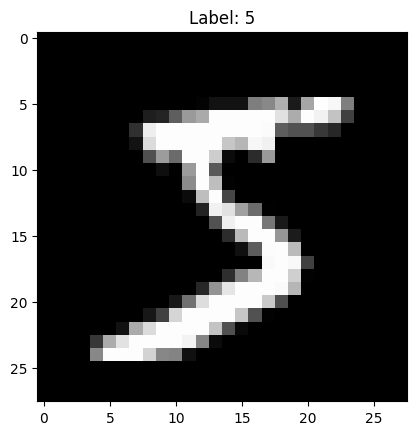

In [ ]:
# Plot the input image
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import math

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
n_qubits = 4
patch_size = 2
layers = 1
levels=3

**🔹 Quantum Circuit Definition**

- A quantum circuit is built using PennyLane and integrated with TensorFlow.

- The circuit structure:
  - **Feature map**: Applies `RY` rotations using input data to encode classical information.
  - **Variational layer**:
    - Applies trainable `RY` rotations for each qubit.
    - Adds entanglement between neighboring qubits using `CNOT` gates.
  - **Measurement**: Measures the expectation value of `PauliZ` on each qubit.

- The circuit returns a list of `n_qubits` expectation values for further use.


In [ ]:
dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev, interface="tf")
@tf.autograph.experimental.do_not_convert
def quantum_circuit(inputs, weights):
    for i in range(n_qubits):  # feature map
        qml.RY(np.pi * inputs[i], wires=i)

    for l in range(layers):
        for i in range(n_qubits):
            qml.RY(weights[l][i], wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # Return the list of expectation values directly — no tf.stack
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

**🔹 Image Patch Extraction**

- Defines `extract_patches()` function to divide the 28×28 image into non-overlapping patches.

- Each patch is of size `patch_size × patch_size` (2×2).

- Each 2×2 patch is flattened to a vector and stacked into a tensor.

- This step is essential to map image patches to the fixed input size required by quantum circuits.


In [ ]:
def extract_patches(img, patch_size):
    patches = []
    for i in range(0, img.shape[0], patch_size):
        for j in range(0, img.shape[1], patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(tf.reshape(patch, [-1]))
    return tf.stack(patches)

**🔹 Initialize Trainable Quantum Weights**

- Random seeds are set for reproducibility.

- Three sets of weights (`weights_l1`, `weights_l2`, `weights_l3`) are initialized for three levels.

- Each set has shape `(layers, n_qubits)` which matches the number of trainable gates per layer and per qubit.

- Currently, only `weights_l1` is actively used for building the quantum layer.


In [ ]:
#all_weights = []
tf.random.set_seed(42)
np.random.seed(42)

weights_l1 = tf.Variable(tf.random.normal((layers, n_qubits),stddev=0.1),trainable=True)# no of weights is (layers * n_qubits)
weights_l2 = tf.Variable(tf.random.normal((layers, n_qubits),stddev=0.1),trainable=True)# no of weights is (layers * n_qubits)
weights_l3 = tf.Variable(tf.random.normal((layers, n_qubits),stddev=0.1),trainable=True)# no of weights is (layers * n_qubits)
print("weights in level 1 shape:", weights_l1.shape)

**🔹 Classical Neural Network Model**

- A simple classical neural network is defined using `tf.keras.Sequential`.

- Takes an input of shape `(9,)` – expected to be quantum outputs or processed features.

- Applies a `Dense` layer with 10 output nodes using `softmax` activation.

- Designed to classify digits (0–9) based on quantum-derived features.


In [ ]:
# Classical model (trainable)
classical_model = tf.keras.Sequential([
    tf.keras.Input(shape=(9,)),
    tf.keras.layers.Dense(10, activation='softmax')
])
print("combining with classical model")

# this is for classical parameteres defined for the classical part

**🔹 Optimizer and Loss Function**

- Defines the **Adam optimizer** with a learning rate of 0.01.

- Uses **Sparse Categorical Crossentropy** as the loss function — suitable for multi-class classification where labels are integers (e.g., MNIST digits 0–9).


In [ ]:
# Optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

concatenating quantum part together

**🔹 Forward Pass (Quantum + Classical Integration)**

- **Level 1**:
  - Extracts 2×2 patches from the 28×28 image → gets 196 patches.
  - Each patch is processed by the quantum circuit with `weights_l1`.
  - Output from 4 qubits is averaged into a single value per patch.
  - All 196 values are reshaped back to a 14×14 matrix (like an intermediate feature map).

- **Level 2**:
  - The 14×14 output is again patched (2×2) → results in 49 patches.
  - Each patch is passed through the quantum circuit with `weights_l2`.
  - Again, outputs are averaged and reshaped into a 7×7 image.

- **Level 3**:
  - The 7×7 output is patched into 9 patches.
  - These are passed through the quantum circuit using `weights_l3`.
  - Outputs are reduced to 9 values → final feature vector of shape (1, 9).

- The 9-dimensional quantum-processed feature vector is fed into the **classical model** for classification.


In [ ]:
def forward(x_img):
    # First layer: Extract patches from original image (28x28 -> 14x14 patches -> 196 patches)
    patches1 = extract_patches(x_img, patch_size)  # Shape: (196, 4)
    print("patches1 after extracting:", patches1.shape)

    # Process first layer patches
    q_outputs1 = []
    for i in range(patches1.shape[0]):
        patch = patches1[i]
        q_output1 = quantum_circuit(patch, weights_l1)  # Returns list of 4 values
        if isinstance(q_output1, (list, tuple)):
            q_output1 = tf.stack(q_output1)  # Convert list to tensor
        # Take real part to avoid complex number warnings
        q_output1 = tf.cast(tf.math.real(q_output1), tf.float32)
        # Take average of the 4 quantum features
        q_output_1_avg = tf.reduce_mean(q_output1)  # Average to single value
        q_outputs1.append(q_output_1_avg)

    q_outputs1 = tf.stack(q_outputs1)  # Shape: (196,) - one value per patch
    q_outputs1_reshaped = tf.reshape(q_outputs1, (14, 14))  # Reshape back to 14x14 image
    print("q_outputs1 shape after reshaping to image:", q_outputs1_reshaped.shape)

    # Second layer: Extract patches from the 14x14 quantum output (14x14 -> 7x7 patches -> 49 patches)
    patches2 = extract_patches(q_outputs1_reshaped, patch_size)  # Shape: (49, 4)
    print("patches2 after extracting:", patches2.shape)

    # Process second layer patches
    q_outputs2 = []
    for i in range(patches2.shape[0]):
        patch = patches2[i]
        q_output2 = quantum_circuit(patch, weights_l2)  # Returns list of 4 values
        if isinstance(q_output2, (list, tuple)):
            q_output2 = tf.stack(q_output2)  # Convert list to tensor
        # Take real part to avoid complex number warnings
        q_output2 = tf.cast(tf.math.real(q_output2), tf.float32)
        # Take average of the 4 quantum features
        q_output_2_avg = tf.reduce_mean(q_output2)  # Average to single value
        q_outputs2.append(q_output_2_avg)

    q_outputs2 = tf.stack(q_outputs2)  # Shape: (49,) - one value per patch
    q_outputs2_reshaped = tf.reshape(q_outputs2, (7, 7))  # Reshape back to 7x7 image
    print("q_outputs2 shape after reshaping to image:", q_outputs2_reshaped.shape)

    # Third layer: Extract patches from the 7x7 quantum output (7x7 -> 3x3 patches -> 9 patches)
    patches3 = extract_patches(q_outputs2_reshaped, patch_size)  # Shape: (9, 4)
    print("patches3 after extracting:", patches3.shape)

    # Process third layer patches
    q_outputs3 = []
    for i in range(patches3.shape[0]):
        patch = patches3[i]
        q_output3 = quantum_circuit(patch, weights_l3)  # Returns list of 4 values
        if isinstance(q_output3, (list, tuple)):
            q_output3 = tf.stack(q_output3)  # Convert list to tensor
        # Take real part to avoid complex number warnings
        q_output3 = tf.cast(tf.math.real(q_output3), tf.float32)
        # Take average of the 4 quantum features
        q_output_3_avg = tf.reduce_mean(q_output3)  # Average to single value
        q_outputs3.append(q_output_3_avg)

    q_outputs3 = tf.stack(q_outputs3)  # Shape: (9,) - one value per patch
    q_outputs3_reshaped = tf.reshape(q_outputs3, (1, -1))  # Shape: (1, 9) - flattened
    print("q_outputs3 shape:", q_outputs3_reshaped.shape)

    # Pass through classical model
    logits = classical_model(q_outputs3_reshaped)
    print("shape after sending the third quantum layer to classical model:", logits.shape)

    return logits

**🔹 Training Step with Gradient Tape**

- Wraps the forward pass using `tf.GradientTape()` to compute gradients.

- Reshapes the label to match the model’s output.

- Computes the loss using the predefined loss function.

- Collects **trainable variables**: `weights_l1`, `weights_l2`, and classical model weights.

- Calculates gradients and applies them using the Adam optimizer.

- Returns both the loss and model predictions.


In [ ]:
@tf.function
def train_step(x_img, y_label):
    with tf.GradientTape() as tape:
        predictions = forward(x_img)  # shape: (1, 10)
        loss = loss_fn(tf.reshape(y_label, (1,)), predictions)
        tf.print("Loss:", loss)

    trainable_vars = [weights_l1, weights_l2] + classical_model.trainable_variables

    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss, predictions

**🔹 Training Loop (Single Image, 20 Epochs)**

- Runs for 20 epochs on a single image and label.

- In each epoch:
  - Performs forward + backward pass using `train_step()`.
  - Calculates and prints loss and accuracy.
  - Logs detailed output:
    - Prediction shape
    - Prediction values
    - Ground truth label
    - Final predicted class

- This loop helps track how the model evolves while training on a very small input set.


In [ ]:
epochs = 20
for epoch in range(epochs):
    loss, predictions = train_step(img, tf.constant(label))
    acc = tf.keras.metrics.sparse_categorical_accuracy(tf.reshape(tf.constant([label]), (1,)), predictions)

    print(f"Epoch {epoch+1:2d}/{epochs} | Loss: {loss.numpy():.6f} | Accuracy: {acc.numpy()[0]:.4f}")
    print(f"  Detailed info at epoch {epoch+1}:")
    print(f"    Predictions shape: {predictions.shape}")
    print(f"    Predictions: {predictions.numpy().flatten()}")
    print(f"    True label: {label}")
    print(f"    Predicted class: {tf.argmax(predictions, axis=1).numpy()[0]}")
    print()

patches1 after extracting: (196, 4)
q_outputs1 shape after reshaping to image: (14, 14)
patches2 after extracting: (49, 4)
q_outputs2 shape after reshaping to image: (7, 7)
patches3 after extracting: (9, 4)
q_outputs3 shape: (1, 9)
shape after sending the third quantum layer to classical model: (1, 10)
patches1 after extracting: (196, 4)
q_outputs1 shape after reshaping to image: (14, 14)
patches2 after extracting: (49, 4)
q_outputs2 shape after reshaping to image: (7, 7)
patches3 after extracting: (9, 4)
q_outputs3 shape: (1, 9)
shape after sending the third quantum layer to classical model: (1, 10)
Loss: 3.02301121
Epoch  1/20 | Loss: 3.023011 | Accuracy: 0.0000
  Detailed info at epoch 1:
    Predictions shape: (1, 10)
    Predictions: [0.12188376 0.04397007 0.09475879 0.04848508 0.25418234 0.04865448
 0.17412034 0.13260227 0.03500326 0.04633961]
    True label: 5
    Predicted class: 4

Loss: 2.89250278
Epoch  2/20 | Loss: 2.892503 | Accuracy: 0.0000
  Detailed info at epoch 2:
   

In [ ]:
# Testing function
@tf.function
def test_step(x_img, y_label):
    predictions = forward(x_img)  # shape: (1, 10)
    loss = loss_fn(tf.reshape(y_label, (1,)), predictions)
    predicted_class = tf.argmax(predictions, axis=1)[0]
    return loss, predictions, predicted_class

# Test on full test set
def evaluate_model(x_test, y_test, num_samples=None):
    """
    Evaluate the model on test data

    Args:
        x_test: Test images (tensor with shape like (10, 28, 28))
        y_test: Test labels (tensor with shape like (10,))
        num_samples: Number of samples to test (None for all)
    """
    if num_samples is None:
        num_samples = x_test.shape[0]

    total_loss = 0.0
    correct_predictions = 0
    all_predictions = []
    all_true_labels = []

    print(f"Testing on {num_samples} samples...")
    print("-" * 50)

    for i in range(num_samples):
        test_img = x_test[i]  # Shape: (28, 28)
        test_label = y_test[i]

        # Test the model
        loss, predictions, predicted_class = test_step(test_img, tf.constant(test_label))

        # Accumulate metrics
        total_loss += loss.numpy()
        is_correct = (predicted_class.numpy() == test_label)
        if is_correct:
            correct_predictions += 1

        all_predictions.append(predicted_class.numpy())
        all_true_labels.append(test_label)

        # Print progress every 5 samples (since we only have 10)
        if (i + 1) % 5 == 0 or i == 0:
            print(f"Sample {i+1:2d} | True: {test_label} | Pred: {predicted_class.numpy()} | "
                  f"Correct: {'✓' if is_correct else '✗'} | Loss: {loss.numpy():.4f}")

    # Calculate final metrics
    avg_loss = total_loss / num_samples
    accuracy = correct_predictions / num_samples

    print("-" * 50)
    print(f"FINAL RESULTS:")
    print(f"Test Accuracy: {accuracy:.4f} ({correct_predictions}/{num_samples})")
    print(f"Average Loss: {avg_loss:.6f}")
    print("-" * 50)

    return accuracy, avg_loss, all_predictions, all_true_labels

# Example usage - test on your 10 samples
print("Testing model performance...")
test_accuracy, test_loss, predictions, true_labels = evaluate_model(test_images, test_labels)

# Detailed analysis
def analyze_results(predictions, true_labels):
    """Analyze prediction results in detail"""
    from collections import Counter

    # Class-wise accuracy
    class_correct = Counter()
    class_total = Counter()

    for pred, true in zip(predictions, true_labels):
        class_total[true] += 1
        if pred == true:
            class_correct[true] += 1

    print("\nClass-wise Accuracy:")
    print("-" * 30)
    for class_id in sorted(class_total.keys()):
        acc = class_correct[class_id] / class_total[class_id] if class_total[class_id] > 0 else 0
        print(f"Class {class_id}: {acc:.4f} ({class_correct[class_id]}/{class_total[class_id]})")

    # Confusion matrix (simplified)
    print(f"\nMost confused classes:")
    errors = [(true, pred) for pred, true in zip(predictions, true_labels) if pred != true]
    error_counts = Counter(errors)
    for (true, pred), count in error_counts.most_common(5):
        print(f"True: {true} → Predicted: {pred} (happened {count} times)")

# Run detailed analysis
analyze_results(predictions, true_labels)

Testing model performance...
Testing on 10 samples...
--------------------------------------------------
patches1 after extracting: (196, 4)
q_outputs1 shape after reshaping to image: (14, 14)
patches2 after extracting: (49, 4)
q_outputs2 shape after reshaping to image: (7, 7)
patches3 after extracting: (9, 4)
q_outputs3 shape: (1, 9)
shape after sending the third quantum layer to classical model: (1, 10)
Sample  1 | True: 7 | Pred: 5 | Correct: ✗ | Loss: 2.1111
Sample  5 | True: 4 | Pred: 5 | Correct: ✗ | Loss: 2.0862
Sample 10 | True: 9 | Pred: 7 | Correct: ✗ | Loss: 4.7237
--------------------------------------------------
FINAL RESULTS:
Test Accuracy: 0.1000 (1/10)
Average Loss: 2.967358
--------------------------------------------------

Class-wise Accuracy:
------------------------------
Class 0: 0.0000 (0/1)
Class 1: 0.0000 (0/2)
Class 2: 0.0000 (0/1)
Class 4: 0.0000 (0/2)
Class 5: 1.0000 (1/1)
Class 7: 0.0000 (0/1)
Class 9: 0.0000 (0/2)

Most confused classes:
True: 1 → Predict

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import warnings
import numpy as np
tf.keras.backend.set_floatx('float32')
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Filter training data for classes 0 and 5 (30 samples each)
def get_class_samples(images, labels, target_class, num_samples):
    """Get specified number of samples for a target class"""
    class_indices = np.where(labels == target_class)[0]
    selected_indices = class_indices[:num_samples]
    return images[selected_indices], labels[selected_indices]

# Get 30 samples each of class 0 and 5
train_images_0, train_labels_0 = get_class_samples(train_images, train_labels, 0, 30)
train_images_5, train_labels_5 = get_class_samples(train_images, train_labels, 5, 30)

# Combine the training data
train_images_selected = np.concatenate([train_images_0, train_images_5], axis=0)
train_labels_selected = np.concatenate([train_labels_0, train_labels_5], axis=0)

# Shuffle the training data
shuffle_indices = np.random.permutation(len(train_images_selected))
train_images_selected = train_images_selected[shuffle_indices]
train_labels_selected = train_labels_selected[shuffle_indices]

# Normalize training data
train_images_selected = train_images_selected / 255.0
train_images_selected = tf.cast(train_images_selected, tf.float32)

# Prepare test data (100 samples from each class for comprehensive testing)
def get_balanced_test_set(images, labels, samples_per_class=100):
    """Get balanced test set with specified samples per class"""
    test_imgs = []
    test_lbls = []

    for class_id in range(10):  # MNIST has classes 0-9
        class_indices = np.where(labels == class_id)[0]
        selected_indices = class_indices[:samples_per_class]
        test_imgs.append(images[selected_indices])
        test_lbls.append(labels[selected_indices])

    return np.concatenate(test_imgs), np.concatenate(test_lbls)

test_images_balanced, test_labels_balanced = get_balanced_test_set(test_images, test_labels, 100)
test_images_balanced = test_images_balanced / 255.0
test_images_balanced = tf.cast(test_images_balanced, tf.float32)

print(f"Training data shape: {train_images_selected.shape}")
print(f"Training labels shape: {train_labels_selected.shape}")
print(f"Training class distribution: {np.bincount(train_labels_selected)}")
print(f"Test data shape: {test_images_balanced.shape}")
print(f"Test labels shape: {test_labels_balanced.shape}")
print(f"Test class distribution: {np.bincount(test_labels_balanced)}")

# Quantum circuit setup
import pennylane as qml
from pennylane import numpy as pnp
import math

n_qubits = 4
patch_size = 2
layers = 1
levels = 3

dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface="tf")
@tf.autograph.experimental.do_not_convert
def quantum_circuit(inputs, weights):
    for i in range(n_qubits):  # feature map
        qml.RY(pnp.pi * inputs[i], wires=i)

    for l in range(layers):
        for i in range(n_qubits):
            qml.RY(weights[l][i], wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def extract_patches(img, patch_size):
    patches = []
    for i in range(0, img.shape[0], patch_size):
        for j in range(0, img.shape[1], patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(tf.reshape(patch, [-1]))
    return tf.stack(patches)

# Initialize quantum weights
tf.random.set_seed(42)
pnp.random.seed(42)

weights_l1 = tf.Variable(tf.random.normal((layers, n_qubits), stddev=0.1), trainable=True)
weights_l2 = tf.Variable(tf.random.normal((layers, n_qubits), stddev=0.1), trainable=True)
weights_l3 = tf.Variable(tf.random.normal((layers, n_qubits), stddev=0.1), trainable=True)

# Classical model
classical_model = tf.keras.Sequential([
    tf.keras.Input(shape=(9,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

def forward(x_img):
    # First layer
    patches1 = extract_patches(x_img, patch_size)

    q_outputs1 = []
    for i in range(patches1.shape[0]):
        patch = patches1[i]
        q_output1 = quantum_circuit(patch, weights_l1)
        if isinstance(q_output1, (list, tuple)):
            q_output1 = tf.stack(q_output1)
        q_output1 = tf.cast(tf.math.real(q_output1), tf.float32)
        q_output_1_avg = tf.reduce_mean(q_output1)
        q_outputs1.append(q_output_1_avg)

    q_outputs1 = tf.stack(q_outputs1)
    q_outputs1_reshaped = tf.reshape(q_outputs1, (14, 14))

    # Second layer
    patches2 = extract_patches(q_outputs1_reshaped, patch_size)

    q_outputs2 = []
    for i in range(patches2.shape[0]):
        patch = patches2[i]
        q_output2 = quantum_circuit(patch, weights_l2)
        if isinstance(q_output2, (list, tuple)):
            q_output2 = tf.stack(q_output2)
        q_output2 = tf.cast(tf.math.real(q_output2), tf.float32)
        q_output_2_avg = tf.reduce_mean(q_output2)
        q_outputs2.append(q_output_2_avg)

    q_outputs2 = tf.stack(q_outputs2)
    q_outputs2_reshaped = tf.reshape(q_outputs2, (7, 7))

    # Third layer
    patches3 = extract_patches(q_outputs2_reshaped, patch_size)

    q_outputs3 = []
    for i in range(patches3.shape[0]):
        patch = patches3[i]
        q_output3 = quantum_circuit(patch, weights_l3)
        if isinstance(q_output3, (list, tuple)):
            q_output3 = tf.stack(q_output3)
        q_output3 = tf.cast(tf.math.real(q_output3), tf.float32)
        q_output_3_avg = tf.reduce_mean(q_output3)
        q_outputs3.append(q_output_3_avg)

    q_outputs3 = tf.stack(q_outputs3)
    q_outputs3_reshaped = tf.reshape(q_outputs3, (1, -1))

    # Classical layer
    logits = classical_model(q_outputs3_reshaped)
    return logits

@tf.function
def train_step(x_img, y_label):
    with tf.GradientTape() as tape:
        predictions = forward(x_img)
        loss = loss_fn(tf.reshape(y_label, (1,)), predictions)

    trainable_vars = [weights_l1, weights_l2, weights_l3] + classical_model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss, predictions

# Training loop
print("Starting training on 60 images (30 each of class 0 and 5)...")
print("=" * 60)

epochs = 10
batch_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    correct_predictions = 0

    # Shuffle training data each epoch
    shuffle_indices = np.random.permutation(len(train_images_selected))
    shuffled_images = tf.gather(train_images_selected, shuffle_indices)
    shuffled_labels = tf.gather(train_labels_selected, shuffle_indices)

    for i in range(len(shuffled_images)):
        img = shuffled_images[i]
        label = shuffled_labels[i]

        loss, predictions = train_step(img, tf.constant(label))
        epoch_loss += loss.numpy()

        predicted_class = tf.argmax(predictions, axis=1).numpy()[0]
        if predicted_class == label:
            correct_predictions += 1

    avg_loss = epoch_loss / len(shuffled_images)
    accuracy = correct_predictions / len(shuffled_images)
    batch_losses.append(avg_loss)

    print(f"Epoch {epoch+1:2d}/{epochs} | Loss: {avg_loss:.6f} | Accuracy: {accuracy:.4f}")

print("\nTraining completed!")
print("=" * 60)

# Testing function
@tf.function
def test_step(x_img, y_label):
    predictions = forward(x_img)
    loss = loss_fn(tf.reshape(y_label, (1,)), predictions)
    predicted_class = tf.argmax(predictions, axis=1)[0]
    return loss, predictions, predicted_class

def evaluate_model(x_test, y_test, num_samples=None):
    """Evaluate model on test data"""
    if num_samples is None:
        num_samples = x_test.shape[0]

    total_loss = 0.0
    correct_predictions = 0
    all_predictions = []
    all_true_labels = []
    class_correct = {}
    class_total = {}

    print(f"Testing on {num_samples} samples...")
    print("-" * 50)

    for i in range(num_samples):
        test_img = x_test[i]
        test_label = y_test[i].numpy() if hasattr(y_test[i], 'numpy') else y_test[i]

        loss, predictions, predicted_class = test_step(test_img, tf.constant(test_label))

        total_loss += loss.numpy()
        is_correct = (predicted_class.numpy() == test_label)
        if is_correct:
            correct_predictions += 1

        all_predictions.append(predicted_class.numpy())
        all_true_labels.append(test_label)

        # Track class-wise accuracy
        if test_label not in class_total:
            class_total[test_label] = 0
            class_correct[test_label] = 0
        class_total[test_label] += 1
        if is_correct:
            class_correct[test_label] += 1

        # Print progress every 100 samples
        if (i + 1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    avg_loss = total_loss / num_samples
    overall_accuracy = correct_predictions / num_samples

    print("-" * 50)
    print(f"OVERALL RESULTS:")
    print(f"Test Accuracy: {overall_accuracy:.4f} ({correct_predictions}/{num_samples})")
    print(f"Average Loss: {avg_loss:.6f}")
    print("-" * 50)

    # Class-wise results
    print("\nCLASS-WISE ACCURACY:")
    print("-" * 30)
    for class_id in sorted(class_total.keys()):
        acc = class_correct[class_id] / class_total[class_id] if class_total[class_id] > 0 else 0
        print(f"Class {class_id}: {acc:.4f} ({class_correct[class_id]}/{class_total[class_id]})")

    return overall_accuracy, avg_loss, all_predictions, all_true_labels

# Test the model
print("Testing model performance on all classes...")
test_accuracy, test_loss, predictions, true_labels = evaluate_model(test_images_balanced, test_labels_balanced)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(batch_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot confusion matrix visualization
plt.subplot(1, 2, 2)
from collections import Counter
confusion_data = Counter([(true, pred) for true, pred in zip(true_labels, predictions)])

# Create confusion matrix
confusion_matrix = np.zeros((10, 10))
for (true_label, pred_label), count in confusion_data.items():
    confusion_matrix[true_label, pred_label] = count

plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.colorbar()

# Add text annotations
for i in range(10):
    for j in range(10):
        plt.text(j, i, int(confusion_matrix[i, j]),
                ha="center", va="center", color="red" if confusion_matrix[i, j] > 50 else "black")

plt.tight_layout()
plt.show()

print("\nAnalysis Summary:")
print("- The model was trained on 60 images (30 each of class 0 and 5)")
print("- Tested on 1000 images (100 from each of the 10 classes)")
print("- Classes 0 and 5 should show better performance since they were in training")
print("- Other classes rely on the model's ability to generalize")